In [1]:
#Import required packages
import pandas as pd
import numpy as np
import pickle
import sqlite3
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

### Data Import from SQLite

In [2]:
#Save the database file path
file_path = "cushings.db"

#Create the engine & engine connection
engine = create_engine(f'sqlite:///{file_path}', echo=True)
sqlite_connection = engine.connect()

In [3]:
#Read in all records from the database
data_df = pd.read_sql("SELECT * FROM cushings_table_final", sqlite_connection)

2023-08-08 21:48:38,926 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("SELECT * FROM cushings_table_final")
2023-08-08 21:48:38,927 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-08-08 21:48:38,928 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("SELECT * FROM cushings_table_final")
2023-08-08 21:48:38,928 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-08-08 21:48:38,929 INFO sqlalchemy.engine.Engine SELECT * FROM cushings_table_final
2023-08-08 21:48:38,929 INFO sqlalchemy.engine.Engine [raw sql] ()


In [4]:
#Preview the df
data_df.head()

,PatientID,Diagnosis,Breed,Age,Sex,Neutered,WeightChange,Weight,Hospitalised,Vomiting,...,Neurological,Polydipsia,Polyuria,Polyphagia,IncreasedALKP,IncreasedATL_GGT_AST,Hypertensive,LowBloodSugar,Hypothyroid,CruciateSurgery
0,1,1,Jack Russell Terrier,12,M,1,No change,13.00,0,0,...,0,1,1,0,1,1,0,0,0,0
1,2,1,Bichon Frise,12,F,1,No change,9.30,0,0,...,0,1,1,0,1,1,0,0,0,0
2,3,1,West Highland White Terrier,13,F,1,No change,9.82,0,0,...,0,1,1,1,1,1,0,0,0,0
3,4,1,Cocker Spaniel,12,F,1,No change,11.30,1,0,...,0,1,1,0,None,None,0,0,0,0
4,5,1,Crossbreed,9,F,0,No change,9.30,0,0,...,0,1,1,0,1,1,0,0,0,0


In [5]:
#Set PatientID as index
data_df.index = data_df['PatientID']

#Remove PatientID column
del data_df['PatientID']

#Check df
data_df.head()

,Diagnosis,Breed,Age,Sex,Neutered,WeightChange,Weight,Hospitalised,Vomiting,Diarrhoea,...,Neurological,Polydipsia,Polyuria,Polyphagia,IncreasedALKP,IncreasedATL_GGT_AST,Hypertensive,LowBloodSugar,Hypothyroid,CruciateSurgery
PatientID,,,,,,,,,,,,,,,,,,,,,
1,1,Jack Russell Terrier,12,M,1,No change,13.00,0,0,0,...,0,1,1,0,1,1,0,0,0,0
2,1,Bichon Frise,12,F,1,No change,9.30,0,0,0,...,0,1,1,0,1,1,0,0,0,0
3,1,West Highland White Terrier,13,F,1,No change,9.82,0,0,0,...,0,1,1,1,1,1,0,0,0,0
4,1,Cocker Spaniel,12,F,1,No change,11.30,1,0,0,...,0,1,1,0,None,None,0,0,0,0
5,1,Crossbreed,9,F,0,No change,9.30,0,0,1,...,0,1,1,0,1,1,0,0,0,0


### Data Cleaning

In [6]:
#Check data types
data_df.dtypes

Diagnosis                 object
Breed                     object
Age                        int64
Sex                       object
Neutered                   int64
WeightChange              object
Weight                   float64
Hospitalised               int64
Vomiting                   int64
Diarrhoea                  int64
Hepatomegaly               int64
ThinDrySkin                int64
Alopecia                   int64
Pruritus                   int64
MuscleWastageWeakness      int64
Lethargy                   int64
Panting                    int64
Neurological               int64
Polydipsia                 int64
Polyuria                   int64
Polyphagia                 int64
IncreasedALKP             object
IncreasedATL_GGT_AST      object
Hypertensive               int64
LowBloodSugar              int64
Hypothyroid                int64
CruciateSurgery            int64
dtype: object

### Scaling Features with NA values

In [8]:
#Check categories in ALKP variable
data_df['IncreasedALKP'].value_counts()

1    581
0     76
Name: IncreasedALKP, dtype: int64

In [9]:
#Replace NA values with object
data_df['IncreasedALKP'] = data_df['IncreasedALKP'].replace(np.nan, 'N/A')

#Get dummies for breed
alkp_df = pd.get_dummies(data_df['IncreasedALKP'])

#Save column names
alkp_cols = alkp_df.columns.values
alkp_cols 

array(['0', '1', 'N/A'], dtype=object)

In [10]:
#Replace column names
alkp_col_names = {alkp_cols[0]: 'ALKPFalse', alkp_cols[1]: 'ALKPTrue', 'N/A': 'ALKPN/A'}
alkp_df = alkp_df.rename(columns=alkp_col_names)

alkp_df.head()

,ALKPFalse,ALKPTrue,ALKPN/A
PatientID,,,
1,0,1,0
2,0,1,0
3,0,1,0
4,0,0,1
5,0,1,0


In [12]:
#Check categories in ATL variable
data_df['IncreasedATL_GGT_AST'].value_counts()

1    420
0    143
Name: IncreasedATL_GGT_AST, dtype: int64

In [13]:
#Replace NA values with object
data_df['IncreasedATL_GGT_AST'] = data_df['IncreasedATL_GGT_AST'].replace(np.nan, 'N/A')

#Get dummies for breed
atl_df = pd.get_dummies(data_df['IncreasedATL_GGT_AST'])

#Save column names
atl_cols = atl_df.columns.values
atl_cols 


array(['0', '1', 'N/A'], dtype=object)

In [14]:
#Replace column names
atl_col_names = {atl_cols[0]: 'ATLFalse', atl_cols[1]: 'ATLTrue', 'N/A': 'ATLPN/A'}
atl_df = atl_df.rename(columns=atl_col_names)

atl_df.head()

,ATLFalse,ATLTrue,ATLPN/A
PatientID,,,
1,0,1,0
2,0,1,0
3,0,1,0
4,0,0,1
5,0,1,0


### Scaling Feature Values

In [15]:
#Create list of numerical column names
num_columns = ['Age', 'Weight']

#Standard Scale the numerical values
scaled_num_cols = StandardScaler().fit_transform(data_df[num_columns])

#Check scaled data
scaled_num_cols

array([[ 0.70799614, -0.32233216],
       [ 0.70799614, -0.64873217],
       [ 1.05526421, -0.60285974],
       ...,
       [ 0.70799614,  0.55983001],
       [ 1.74980035, -0.63991055],
       [ 1.40253228,  0.07464082]])

In [16]:
#Create df of scaled numerical data
scaled_num_cols_df = pd.DataFrame(scaled_num_cols, columns=num_columns)

#Add the PatientID column as the df index
scaled_num_cols_df.index = data_df.index

#Check df
scaled_num_cols_df.head()

,Age,Weight
PatientID,,
1,0.707996,-0.322332
2,0.707996,-0.648732
3,1.055264,-0.602860
4,0.707996,-0.472300
5,-0.333808,-0.648732


In [17]:
#Create df of boolean data
bool_df = data_df[[ 
    'Neutered', 
    'Hospitalised', 
    'Vomiting', 
    'Diarrhoea', 
    'Hepatomegaly', 
    'ThinDrySkin', 
    'Alopecia', 
    'Pruritus', 
    'MuscleWastageWeakness', 
    'Lethargy', 
    'Panting', 
    'Neurological', 
    'Polydipsia', 
    'Polyuria', 
    'Polyphagia', 
    'Hypertensive', 
    'LowBloodSugar', 
    'Hypothyroid', 
    'CruciateSurgery',
    'Diagnosis']]

bool_df.head()

,Neutered,Hospitalised,Vomiting,Diarrhoea,Hepatomegaly,ThinDrySkin,Alopecia,Pruritus,MuscleWastageWeakness,Lethargy,Panting,Neurological,Polydipsia,Polyuria,Polyphagia,Hypertensive,LowBloodSugar,Hypothyroid,CruciateSurgery,Diagnosis
PatientID,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1
3,1,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1
4,1,1,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1
5,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1


In [18]:
#Encode diagnosis variable with 1 = True, 0 = False
bool_df['Diagnosis'] = bool_df['Diagnosis'].replace({'1': 1, '0': 0})

#Check data types
bool_df.dtypes

C:\Users\kalio\AppData\Local\Temp\ipykernel_32952\3789508764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bool_df['Diagnosis'] = bool_df['Diagnosis'].replace({'1': 1, '0': 0})


Neutered                 int64
Hospitalised             int64
Vomiting                 int64
Diarrhoea                int64
Hepatomegaly             int64
ThinDrySkin              int64
Alopecia                 int64
Pruritus                 int64
MuscleWastageWeakness    int64
Lethargy                 int64
Panting                  int64
Neurological             int64
Polydipsia               int64
Polyuria                 int64
Polyphagia               int64
Hypertensive             int64
LowBloodSugar            int64
Hypothyroid              int64
CruciateSurgery          int64
Diagnosis                int64
dtype: object

In [19]:
#Create df of object variables & boolean with NA
object_df = data_df[['Breed', 'Sex', 'WeightChange']]

#Check df
object_df.head()

,Breed,Sex,WeightChange
PatientID,,,
1,Jack Russell Terrier,M,No change
2,Bichon Frise,F,No change
3,West Highland White Terrier,F,No change
4,Cocker Spaniel,F,No change
5,Crossbreed,F,No change


In [20]:
#Get dummies for sex
sex_df = pd.get_dummies(object_df['Sex'])

#Check df
sex_df.head()

,F,M
PatientID,,
1,0,1
2,1,0
3,1,0
4,1,0
5,1,0


In [21]:
#Get dummies for WeightChange
weightchange_df = pd.get_dummies(object_df['WeightChange'])

#Check df
weightchange_df.head()

,No change,Weight gain,Weight loss
PatientID,,,
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
5,1,0,0


In [22]:
#Get dummies for breed
breed_df = pd.get_dummies(object_df['Breed'])

breed_df.head()

,Bichon Frise,Border Terrier,Boxer,Cavalier King Charles Spaniel,Chihuahua,Cocker Spaniel,Collie,Crossbreed,Jack Russell Terrier,Labrador Retriever,Others,Poodle,Schnauzer,Shih Tzu,Springer Spaniel,Staffordshire Bull Terrier,West Highland White Terrier,Yorkshire Terrier
PatientID,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [23]:
#Concatonate all scaled dataframes
scaled_df = pd.concat([scaled_num_cols_df, sex_df, weightchange_df, breed_df, alkp_df, atl_df, bool_df], axis=1)

#Check df
scaled_df.head()

,Age,Weight,F,M,No change,Weight gain,Weight loss,Bichon Frise,Border Terrier,Boxer,...,Panting,Neurological,Polydipsia,Polyuria,Polyphagia,Hypertensive,LowBloodSugar,Hypothyroid,CruciateSurgery,Diagnosis
PatientID,,,,,,,,,,,,,,,,,,,,,
1,0.707996,-0.322332,0,1,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
2,0.707996,-0.648732,1,0,1,0,0,1,0,0,...,1,0,1,1,0,0,0,0,0,1
3,1.055264,-0.602860,1,0,1,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,1
4,0.707996,-0.472300,1,0,1,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,1
5,-0.333808,-0.648732,1,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1


### Drop NA Values

In [24]:
#NAN summary
scaled_df.isna().sum()

Age                                0
Weight                           127
F                                  0
M                                  0
No change                          0
Weight gain                        0
Weight loss                        0
Bichon Frise                       0
Border Terrier                     0
Boxer                              0
Cavalier King Charles Spaniel      0
Chihuahua                          0
Cocker Spaniel                     0
Collie                             0
Crossbreed                         0
Jack Russell Terrier               0
Labrador Retriever                 0
Others                             0
Poodle                             0
Schnauzer                          0
Shih Tzu                           0
Springer Spaniel                   0
Staffordshire Bull Terrier         0
West Highland White Terrier        0
Yorkshire Terrier                  0
ALKPFalse                          0
ALKPTrue                           0
A

In [25]:
#Remove rows with na values
scaled_df = scaled_df.dropna(subset=['Weight'])

#Check df
scaled_df.isna().sum()

Age                              0
Weight                           0
F                                0
M                                0
No change                        0
Weight gain                      0
Weight loss                      0
Bichon Frise                     0
Border Terrier                   0
Boxer                            0
Cavalier King Charles Spaniel    0
Chihuahua                        0
Cocker Spaniel                   0
Collie                           0
Crossbreed                       0
Jack Russell Terrier             0
Labrador Retriever               0
Others                           0
Poodle                           0
Schnauzer                        0
Shih Tzu                         0
Springer Spaniel                 0
Staffordshire Bull Terrier       0
West Highland White Terrier      0
Yorkshire Terrier                0
ALKPFalse                        0
ALKPTrue                         0
ALKPN/A                          0
ATLFalse            

In [26]:
#Check df
scaled_df.head()

,Age,Weight,F,M,No change,Weight gain,Weight loss,Bichon Frise,Border Terrier,Boxer,...,Panting,Neurological,Polydipsia,Polyuria,Polyphagia,Hypertensive,LowBloodSugar,Hypothyroid,CruciateSurgery,Diagnosis
PatientID,,,,,,,,,,,,,,,,,,,,,
1,0.707996,-0.322332,0,1,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
2,0.707996,-0.648732,1,0,1,0,0,1,0,0,...,1,0,1,1,0,0,0,0,0,1
3,1.055264,-0.602860,1,0,1,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,1
4,0.707996,-0.472300,1,0,1,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,1
5,-0.333808,-0.648732,1,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1


In [27]:
#Number of entries remaining
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1034 entries, 1 to 1161
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            1034 non-null   float64
 1   Weight                         1034 non-null   float64
 2   F                              1034 non-null   uint8  
 3   M                              1034 non-null   uint8  
 4   No change                      1034 non-null   uint8  
 5   Weight gain                    1034 non-null   uint8  
 6   Weight loss                    1034 non-null   uint8  
 7   Bichon Frise                   1034 non-null   uint8  
 8   Border Terrier                 1034 non-null   uint8  
 9   Boxer                          1034 non-null   uint8  
 10  Cavalier King Charles Spaniel  1034 non-null   uint8  
 11  Chihuahua                      1034 non-null   uint8  
 12  Cocker Spaniel                 1034 non-null   u

### Prepare the data

In [28]:
#Save the dependent variable into a single-column array
Y = scaled_df.iloc[:, -1:]

#Check df
Y[0:5]

,Diagnosis
PatientID,
1,1
2,1
3,1
4,1
5,1


In [29]:
#Save the independent variables
X = scaled_df.iloc[:, :-1]

#Check df
X.head()

,Age,Weight,F,M,No change,Weight gain,Weight loss,Bichon Frise,Border Terrier,Boxer,...,Lethargy,Panting,Neurological,Polydipsia,Polyuria,Polyphagia,Hypertensive,LowBloodSugar,Hypothyroid,CruciateSurgery
PatientID,,,,,,,,,,,,,,,,,,,,,
1,0.707996,-0.322332,0,1,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,0.707996,-0.648732,1,0,1,0,0,1,0,0,...,0,1,0,1,1,0,0,0,0,0
3,1.055264,-0.602860,1,0,1,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0
4,0.707996,-0.472300,1,0,1,0,0,0,0,0,...,0,1,0,1,1,0,0,0,0,0
5,-0.333808,-0.648732,1,0,1,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0


In [30]:
#Split the data into training and testing datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, stratify=Y, test_size=0.2)

### Initiate and Train the Model

In [31]:
# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=250, random_state=42)

# Fit the model to your training data
rf_model.fit(X_train, Y_train)

# Evaluate the model
rf_training_score = rf_model.score(X_train, Y_train)
rf_test_score = rf_model.score(X_test, Y_test)

print(f"RandomForest Model Scores")
print(f"Training Data Score: {rf_training_score}")
print(f"Test Data Score: {rf_test_score}")

c:\Users\kalio\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForest Model Scores
Training Data Score: 1.0
Test Data Score: 0.7198067632850241


In [32]:
#Predict the test values
test_predictions = rf_model.predict(X_test)

#Create df of predicted vs. actual test values
predict_dict = {'Prediction': test_predictions, 'Actual': Y_test["Diagnosis"]}
predict_df = pd.DataFrame(predict_dict)

#Check df
predict_df.head()

,Prediction,Actual
PatientID,,
962,0,0
1085,1,0
818,0,0
881,0,0
846,0,0


In [33]:
#Calculate prediction accuracy scores
accuracy_score(Y_test['Diagnosis'], test_predictions)

0.7198067632850241

In [34]:
#Produce Classification report
target_names = ['No Disease (0)', 'Disease (1)']
print("Classification Report:")
print(classification_report(Y_test, test_predictions, target_names=target_names))

Classification Report:
                precision    recall  f1-score   support

No Disease (0)       0.68      0.84      0.75       105
   Disease (1)       0.78      0.60      0.68       102

      accuracy                           0.72       207
     macro avg       0.73      0.72      0.71       207
  weighted avg       0.73      0.72      0.72       207



### Feature Importance

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

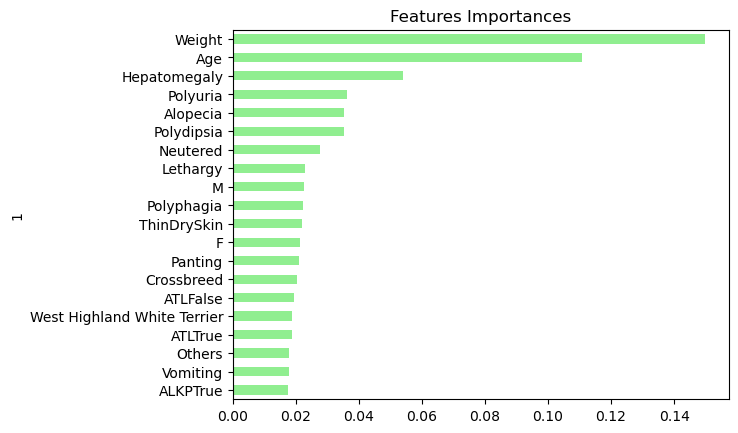

In [35]:
#Save feature importance values to variable
importances = rf_model.feature_importances_

#Transform feature importance values into dataframe
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))

#Set dataframe index
importances_df.set_index(importances_df[1], inplace=True)

#Delete index column
importances_df.drop(columns=1, inplace=True)

#Rename columns
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)

#Sort rows by importance value (descending)
importances_sorted = importances_df.sort_values(by='Feature Importances')

#Save the top 20 features ordered by importance
y = importances_sorted['Feature Importances'].tail(20)

#Plot importance values
y.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)